# Dive Prediction - Matrix Distance Simple Network

*Predicting Seabird Diving Behaviour from GPS data*

This notebook trains a neural network to predict seabirds' dives.

Networks' characteristics:

* *Trajectory window* : 100s
* *Output resolution*: 10s
* *Representation of trajectories* : Matrix Distance
* *Layers* : 1x1 convolutions

## connect to drive

In [ ]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive/")

In [ ]:
%cd drive/My\ Drive/

## load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from utils.trip import * 

In [2]:
data_train = pd.read_csv('./data/data_train.csv')
data_test = pd.read_csv('./data/data_test.csv')

## choose window

In [5]:
# Hyperparameters
window = 600
rescale = 10
variable = ('lon', 'lat')

train_set = TrajDataSet(data_train, window, variable)
d = DistMatrix()
r = Rescale(rescale)

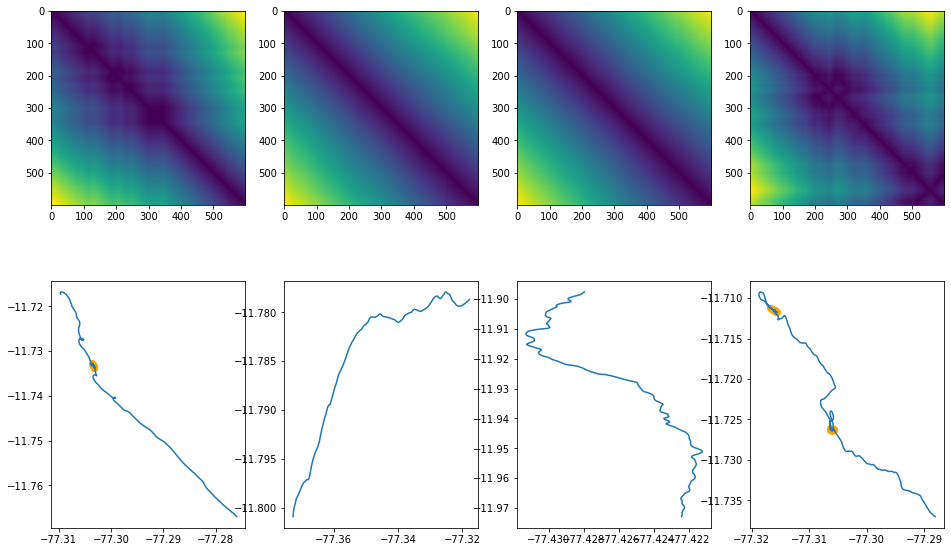

In [17]:
plt.figure(figsize=(16, 10))
idx = np.random.randint(0, len(train_set), 4)

k = -1
for i in idx:
    k += 1
    traj, dive = train_set[i]
    matrix_dist, dive = r(d(train_set[i]))
    

    plt.subplot(2,4, k+1)
    plt.imshow(matrix_dist)

    plt.subplot(2,4, k+5)
    dive = [dive[i] for i in range(len(dive)) for k in range(rescale) ]
    plt.plot(traj[0,:], traj[1,:])
    plt.scatter(traj[0, np.array(dive, dtype = 'bool')], traj[1,np.array(dive, dtype = 'bool')], c='orange')

# Neural Network

In [18]:
# hyperparameters
batch_size = 8
learning_rate = 0.01

train_set = TrajDataSet(data_train, window, variable, transform = transforms.Compose([Rescale(rescale), DistMatrix(), ToTensor()]))
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers = 0, shuffle = True, drop_last=False)

In [19]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.im_cnn_1 = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.Conv2d(1, 4, kernel_size = 1, stride = 1, padding = 0, dilation = 1),
            nn.ReLU(),
            nn.Conv2d(4, 4, kernel_size = 1, stride = 1, padding = 0, dilation = 1),
            nn.ReLU()
        )

        self.im_pooling_1 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 50, stride = 2, padding = 24, dilation = 1)
        )

        self.im_cnn_2 = nn.Sequential(
            nn.BatchNorm2d(4),
            nn.Conv2d(4, 8, kernel_size = 1, stride = 1, padding = 0, dilation = 1),
            nn.ReLU(),
            nn.Conv2d(8, 8, kernel_size = 1, stride = 1, padding = 0, dilation = 1),
            nn.ReLU()
        )

        self.im_pooling_2 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 15, stride = 2, padding = 7, dilation = 1)
        )

        self.im_cnn_3 = nn.Sequential(
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, kernel_size = 1, stride = 1, padding = 0, dilation = 1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size = 1, stride = 1, padding = 0, dilation = 1),
            nn.ReLU()
        )

        self.im_pooling_3 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 11, stride = 2, padding = 5, dilation = 4)
        )
       
        self.dt_cnn_1 = nn.Sequential(
            nn.BatchNorm1d(16),
            nn.Conv1d(16, 1, kernel_size = 1, stride = 1, padding = 0, dilation = 1)
        )
                
    def forward(self, x):
        # CNN
        out = self.im_cnn_1(x)
        out = self.im_pooling_1(out)
        out = self.im_cnn_2(out)
        out = self.im_pooling_2(out)
        out = self.im_cnn_3(out)
        out = self.im_pooling_3(out)

        # 
        out = torch.sum(out, 2)
        out = self.dt_cnn_1(out)

        return out

def get_score(out, y):
    out, y = out.cpu(), y.cpu()
    out = 1*(out>0)
    true_positive = np.mean(out[y == True].numpy()) 
    true_negative = 1-np.mean(out[y == False].numpy())
    
    return (round(true_positive*100) , round(true_negative*100))

In [20]:
# get sample
x, y = next(iter(train_loader)) 
weight = torch.FloatTensor([15])

# Forward model
model = ConvNet()

out = model(x)

# Loss and score
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss(pos_weight = weight)
criterion(out, y)
get_score(out, y)

(79.0, 46.0)

## Training

In [21]:
# # switch to GPU
# model = ConvNet()
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)
# weight = weight.to(device)
# criterion = nn.BCEWithLogitsLoss(pos_weight = weight)

In [22]:
# Train the model
list_loss = []
list_score = []
i = 0

for epoch in range(1):
    for batch, (x, y) in enumerate(train_loader):
        i+=1

#         # send to GPU
#         x, y = x.to(device), y.to(device)

        # Run the forward pass
        out = model(x)
        loss = criterion(out, y)

        # Backprop and perform optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:

            score = get_score(out,y)
            list_loss.append(loss.item())
            list_score.append(score)

            print('Epoch {}, Step {}, Loss: {}, True Positive : {}, True Negative : {} %'
                    .format(epoch+1, i + 1, loss.item(), score[0], score[1]))

KeyboardInterrupt: 

## Testing

In [ ]:
dive_real = []
dive_estim = []

for i in data_test.trip.unique():
    # create dataset for a trajectory
    t = data_test[data_test.trip == i].copy()    
    test_set = TrajDataSet(t, window, variable, transform = transforms.Compose([Rescale(rescale), DistMatrix(), ToTensor()]))
    test_set_part = [test_set[i] for i in range(len(test_set)) if i%rescale == 0]
    
    # Test the model
    estim = np.zeros(int((len(t))/rescale))
    nb = np.zeros(int((len(t))/rescale))
    
    list_out = []
    model.eval()
    k = 0
    with torch.no_grad():
        for (x, y) in test_set_part:
            # send to GPU
            x, y = x.to(device), y.to(device)

            # Run the forward pass
            out = model(x.unsqueeze(0))
            
            estim[k:k + round(window/rescale)] += out.cpu().squeeze().numpy()
            nb[k:k + round(window/rescale)] += 1
            k+=1

    
    # remove extra lines
    t = t.drop(t.tail(len(t)%rescale ).index)
    real = np.array([np.max(t.dive[i:i+rescale]) for i in range(len(t)) if i%rescale == 0])
    
    # add to list by trajectory
    dive_real.append(real)
    dive_estim.append(estim/nb)
    
    print(i)

In [ ]:
threshold = 0
dive_plot = np.array([1*(estim[i]>threshold)  for i in range(len(estim)) for k in range(rescale) ])

In [ ]:
plt.figure(figsize= (12, 5))
plt.subplot(1, 2, 1)
plt.plot(np.array(t.lon), np.array(t.lat))
plt.scatter(t.lon[t.dive == 1], t.lat[t.dive == 1], c = 'orange')

plt.subplot(1, 2, 2)
plt.plot(np.array(t.lon), np.array(t.lat))
plt.scatter(t.lon[dive_plot == 1], t.lat[dive_plot == 1], c = 'red')

## score

In [ ]:
# globally
all_real = 1* (np.hstack(dive_real)> 0)
all_estim = 1* (np.hstack(dive_estim) > 0)

true_positive = np.mean(all_estim[all_real == 1])
true_negative = 1-np.mean(all_estim[all_real == 0])

true_positive, true_negative

In [ ]:
# for each trip
fig, ax = plt.subplots()
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

for i in range(len(dive_real)):
    
    real = 1*(dive_real[i]>0)
    estim = 1*(dive_estim[i]>0)
    
    true_positive = np.mean(estim[real == 1])
    true_negative = 1-np.mean(estim[real == 0])

    ax.scatter(1-true_negative, true_positive, c = 'orange')
    
    print((true_positive, true_negative))

# ROC curve

Change the decision threshold

In [ ]:
# globally
TP = []
FP = []

all_real = 1* (np.hstack(dive_real)> 0)    
for tt in np.arange(-5, 5, 0.1):
    all_estim = 1* (np.hstack(dive_estim) > tt)
    true_positive = np.mean(all_estim[all_real == 1])
    true_negative = 1-np.mean(all_estim[all_real == 0])
    TP.append(true_positive)
    FP.append(1-true_negative)

In [ ]:
plt.plot(np.array(FP), np.array(TP))

In [ ]:
data = {'model': 'deep_network_matrix',
        'FP':  FP,
        'TP': TP
        }

df = pd.DataFrame (data, columns = ['model','FP','TP'])

df.to_csv('./roc_deep_network_matrix.csv', index = False)
# df.to_csv('./roc/roc_deep_network_matrix.csv', index = False)